In [1]:
import os
import shutil
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_class_names(dataset_path):
    """
    Extracts the names of the classes from the dataset directory structure.

    Args:
        dataset_path: The path to the dataset directory.

    Returns:
        A list of class names.
    """
    class_names = []
    train_dir = os.path.join(dataset_path, 'train')
    for dirpath, dirnames, filenames in os.walk(train_dir):
        for dirname in dirnames:
            class_names.append(dirname)
    return class_names

dataset_path = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\EMPDS"
class_names = get_class_names(dataset_path)
print(class_names)
print(len(class_names))

['Acacia Gumefora', 'Agave Sisal', 'Ajuga', 'Allophylus', 'Aloe_Ankoberenisis', 'Aloe_Debrana', 'Archirantus', 'Bederjan', 'Beresemma_Abysinica', 'Biden', 'Calpurnia', 'Carissa_Spinanrum', 'Chenopodium', 'Chlorodundurum', 'Climatis', 'Clutea', 'Cordia', 'Crotun', 'Dovianus', 'Eberighia', 'Echinopes_Kebericho', 'Ficus_Sur', 'Hagnia_Abbysinica', 'Jesminium', 'Laggeria', 'Leonotes', 'Leucas', 'Linipia_Adonesisis', 'Lobelia_Rehinopetanum', 'Melitia', 'Messa_Lanceolata', 'Osirus', 'Phytolleca', 'Plantago', 'Rumex_Abbysinica', 'Rumix_Nervo', 'Senecio', 'Stephania_Abbysinica', 'Thymus_Schimperia', 'Uritica', 'Verbasucum', 'Vernonia_Amag', 'Vernonia_Leop', 'Zeneria_Scabra']
44


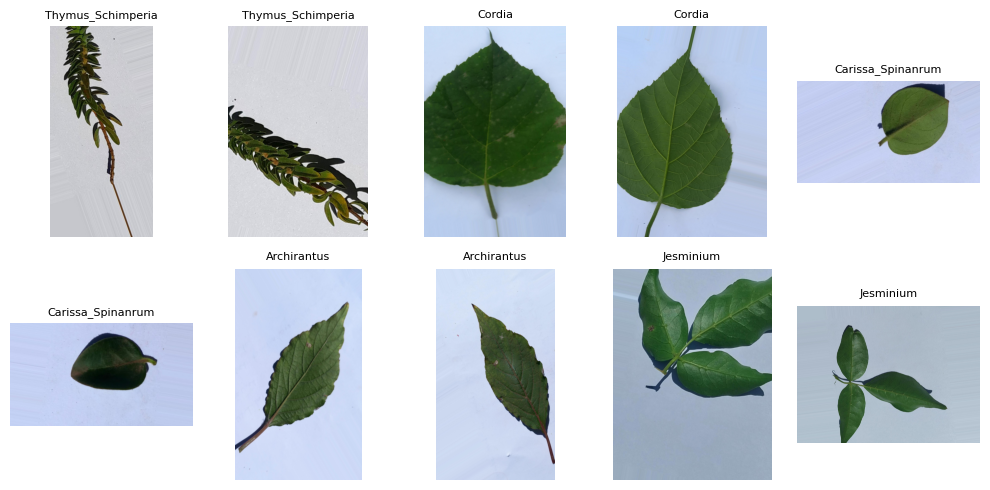

In [3]:
import os
import random
import matplotlib.pyplot as plt

def get_random_images(train_folder, num_images_per_species=2, max_species=5):
  """
  Selects random images from multiple subfolders within a train folder.

  Args:
    train_folder: Path to the main train folder.
    num_images_per_species: Number of random images to select per species.
    max_species: Maximum number of species to sample from.

  Returns:
    A list of image paths and a list of corresponding species labels.
  """

  image_paths = []
  species_labels = []
  selected_species = random.sample(os.listdir(train_folder), max_species)
  for species_folder in selected_species:
    species_path = os.path.join(train_folder, species_folder)
    if os.path.isdir(species_path):
      images = [os.path.join(species_path, img) for img in os.listdir(species_path)]
      selected_images = random.sample(images, min(num_images_per_species, len(images)))
      image_paths.extend(selected_images)
      species_labels.extend([species_folder] * len(selected_images))
  return image_paths, species_labels

# Example usage
train_folder = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\EMPDS\train"  # Replace with the actual path
image_paths, species_labels = get_random_images(train_folder)

# Display the images with annotations
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
  img = plt.imread(image_paths[i])
  ax.imshow(img)
  ax.set_title(species_labels[i], fontsize=8)  # Set species as title
  ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
def count_images(folder_path):
    """
    Counts the number of images in a folder recursively.

    Args:
        folder_path: The path to the folder.

    Returns:
        The total number of images in the folder.
    """
    total_images = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                total_images += 1
    return total_images

dataset_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\EMPDS"
train_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\EMPDS\train"
val_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\EMPDS\val"

train_count = count_images(train_dir)
val_count = count_images(val_dir)
dataset_count = count_images(dataset_dir)

print("Number of images in the dataset:", dataset_count)
print("Number of images in train folder:", train_count)
print("Number of images in validation folder:", val_count)

Number of images in the dataset: 12433
Number of images in train folder: 9766
Number of images in validation folder: 2667


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
#from vit_pytorch.t2t import T2TViT
from timm import create_model

In [5]:
def create_datasets_and_loaders():
    # Base transform
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Augmentations
    augmentations = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2)
    ])

    # Load the original dataset
    original_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=base_transform)

    # Create an augmented dataset
    augmented_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=augmentations)

    # Combine the original and augmented datasets
    trainset = ConcatDataset([original_dataset, augmented_dataset])

    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    valset = torchvision.datasets.ImageFolder(root=val_dir, transform=base_transform)
    valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

    return trainloader, valloader, original_dataset.classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
trainloader, valloader, classes = create_datasets_and_loaders()
num_classes = len(classes)
results_log = []
num_classes

44

## Helper functions for evaluation and plotting

In [7]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import jaccard_score, roc_auc_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import matplotlib.colors as mcolors

In [8]:
# Plotting learning curves

def plot_learning_curves(results, model_name, dataset_name):
    """
    Creates and saves plots for training/validation loss and accuracy curves.
    
    Args:
        results: List of lists containing metrics for each epoch
        model_name: Name of the model being trained
        dataset_name: Name of the dataset used for training
        
    Returns:
        None. Saves two plots in the Learning Curves directory:
        1. Loss curves plot
        2. Accuracy curves plot
    """
    # Create directory for saving plots
    base_dir = "Plots/Learning Curves"
    dataset_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)
    
    # Extract metrics
    epochs = [r[0] for r in results]
    train_loss = [r[1] for r in results]
    train_acc = [r[2] for r in results]
    val_loss = [r[9] for r in results]  # Index 9 for validation loss
    val_acc = [r[10] for r in results]  # Index 10 for validation accuracy
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Plot Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Save loss plot
    loss_plot_path = os.path.join(dataset_dir, f'{model_name}_loss_curves.png')
    plt.savefig(loss_plot_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    # Plot Accuracy Curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save accuracy plot
    acc_plot_path = os.path.join(dataset_dir, f'{model_name}_accuracy_curves.png')
    plt.savefig(acc_plot_path, bbox_inches='tight', dpi=300)
    plt.close()


In [15]:
# Plotting the confusion matrices
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score, roc_auc_score

conf_matrix_dir = r"C:\Users\CoolA\Code\Medicinal Leaves\Dataset 3\Plots\Conf Matrices"

def plot_confusion_matrix(y_true, y_pred, title):
    """
    Creates and saves an enhanced confusion matrix visualization with a logarithmic color scale.

    Args:
        y_true: Ground truth labels as a tensor
        y_pred: Model predictions as a tensor
        title: String containing the model name
    
    Returns:
        None. Saves the confusion matrix plot as a PNG file
    """
    # Check if y_true and y_pred are PyTorch tensors and convert them to NumPy arrays if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()

    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Now, compute the confusion matrix with NumPy arrays
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate confusion matrix
    #cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    
    # Create figure with appropriate size
    plt.figure(figsize=(16, 12))

    # Create a logarithmic normalization for the color scale
    norm = mcolors.LogNorm(vmin=cm.min() + 1, vmax=cm.max())

    # Create heatmap with customized parameters
    sns.heatmap(
        cm,
        cmap='Blues',
        norm=norm,  # Apply logarithmic normalization
        square=True,  # Make cells square
        cbar_kws={'label': 'Count (Log Scale)', 'shrink': .8},
        annot=False,  # Turn off cell annotation to avoid clutter
        linewidths=0.1,  # Thin lines between cells
        linecolor='gray'
    )
    
    # Customize title and labels
    plt.title(f'Confusion Matrix - {title}', pad=20, size=16)
    plt.ylabel('True Label', labelpad=10)
    plt.xlabel('Predicted Label', labelpad=10)
    
    # Rotate axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Only show every nth tick to reduce crowding
    n = max(1, len(cm) // 15)  # Adjust tick frequency based on number of classes
    plt.xticks(np.arange(0, len(cm), n))
    plt.yticks(np.arange(0, len(cm), n))
    
    # Add gridlines for better readability
    plt.grid(False)
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    # Save with high DPI for better quality
    filename = os.path.join(conf_matrix_dir, f'{title}_confusion_matrix.png')
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

# Optional: If you want to customize colors and style
def set_plotting_style():
    """
    Sets consistent plotting style for better visualizations.
    Call this once before creating plots.
    """
    plt.style.use('seaborn')
    sns.set_style("whitegrid", {
        'axes.grid': False,
        'axes.spines.top': False,
        'axes.spines.right': False
    })
    
    # Custom color palette
    colors = sns.color_palette("Blues", n_colors=9)
    sns.set_palette(colors)

In [10]:
# Function to calculate evaluation metrics
def evaluate_model_performance(y_true, y_pred, y_proba, average='macro'):
    """
    Computes various performance metrics for model evaluation.

    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels by the model
        y_proba: Model prediction probabilities
        average: Averaging method for metrics like precision, recall, f1

    Returns:
        Dictionary containing evaluation metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average=average)
    metrics['recall'] = recall_score(y_true, y_pred, average=average)
    metrics['f1_score'] = f1_score(y_true, y_pred, average=average)
    metrics['log_loss'] = log_loss(y_true, y_proba)
    
    # Jaccard similarity (Intersection over Union)
    metrics['jaccard'] = jaccard_score(y_true, y_pred, average=average)
    
    # ROC-AUC (only for binary classification or each class separately in multiclass)
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba, average=average, multi_class='ovr')
    except ValueError:
        metrics['roc_auc'] = "N/A"  # Only applies when the task is multiclass and probabilities are not binary
    
    return metrics

## Loading and training the CNN models

In [11]:
import torchvision.models as models

models_list = [
    models.resnet50(pretrained=True),
    models.mobilenet_v2(pretrained=True),
    models.densenet121(pretrained=True),
    models.efficientnet_b0(pretrained=True),
    models.vgg16(pretrained=True)
]

In [12]:
def create_datasets_and_loaders():
    # Base transform
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Augmentations
    augmentations = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2)
    ])

    # Load the original dataset
    original_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=base_transform)

    # Create an augmented dataset
    augmented_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=augmentations)

    # Combine the original and augmented datasets
    trainset = ConcatDataset([original_dataset, augmented_dataset])

    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    valset = torchvision.datasets.ImageFolder(root=val_dir, transform=base_transform)
    valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

    return trainloader, valloader

In [16]:
cnn_results = []
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
for model in models_list:
    # Reset datasets and dataloaders
    trainloader, valloader = create_datasets_and_loaders()

    # Set the final fully connected layer according to the model architecture
    if isinstance(model, models.ResNet):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif isinstance(model, models.MobileNetV2):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif isinstance(model, models.DenseNet):
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif isinstance(model, models.EfficientNet):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif isinstance(model, models.VGG):
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Print the number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters of {type(model).__name__}:", total_params)

    # Training setup
    num_epochs = 10
    results = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds, all_labels, all_probas = [], [], []

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                probas = torch.nn.functional.softmax(outputs, dim=1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probas.extend(probas.cpu().numpy())

                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(valloader)
        val_accuracy = 100 * correct_val / total_val

        # Evaluation metrics
        y_true = np.array(all_labels)
        y_pred = np.array(all_preds)
        y_proba = np.array(all_probas)

        metrics = evaluate_model_performance(y_true, y_pred, y_proba)

        results.append([
            epoch + 1, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy,
            metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'],
            metrics['log_loss'], metrics['jaccard'], metrics['roc_auc']
        ])

        print(f"Epoch {epoch + 1}/{num_epochs}: "
      f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
      f"Val Accuracy: {metrics['accuracy']:.2f}%, Precision: {metrics['precision']:.4f}, "
      f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1_score']:.4f}, "
      f"Log Loss: {metrics['log_loss']:.4f}, Jaccard: {metrics['jaccard']:.4f}, "
      f"ROC-AUC: {metrics['roc_auc']:.4f}")

    # Post-training analysis
    plot_confusion_matrix(y_true, y_pred, type(model).__name__)
    plot_learning_curves(results, type(model).__name__, "EMPDS")

    cnn_results.append({
        'model': type(model).__name__,
        'results': results
    })

    print(f"Finished training {type(model).__name__}")
    print('-' * 50)

Parameters of ResNet: 23598188
Epoch 1/10: Train Loss: 0.2820, Train Acc: 92.48%, Val Loss: 0.0773, Val Acc: 97.60%, Val Accuracy: 0.98%, Precision: 0.9751, Recall: 0.9774, F1: 0.9753, Log Loss: 0.0778, Jaccard: 0.9533, ROC-AUC: 0.9999
Epoch 2/10: Train Loss: 0.1794, Train Acc: 94.61%, Val Loss: 0.1392, Val Acc: 95.54%, Val Accuracy: 0.96%, Precision: 0.9588, Recall: 0.9475, F1: 0.9489, Log Loss: 0.1402, Jaccard: 0.9080, ROC-AUC: 0.9999
Epoch 3/10: Train Loss: 0.1607, Train Acc: 95.30%, Val Loss: 0.0815, Val Acc: 97.41%, Val Accuracy: 0.97%, Precision: 0.9747, Recall: 0.9723, F1: 0.9724, Log Loss: 0.0821, Jaccard: 0.9479, ROC-AUC: 0.9999
Epoch 4/10: Train Loss: 0.1430, Train Acc: 95.70%, Val Loss: 0.0399, Val Acc: 98.46%, Val Accuracy: 0.98%, Precision: 0.9823, Recall: 0.9848, F1: 0.9830, Log Loss: 0.0402, Jaccard: 0.9676, ROC-AUC: 1.0000
Epoch 5/10: Train Loss: 0.1393, Train Acc: 95.81%, Val Loss: 0.0558, Val Acc: 98.20%, Val Accuracy: 0.98%, Precision: 0.9827, Recall: 0.9784, F1: 0.9

KeyboardInterrupt: 

In [ ]:
import pickle
# Save the cnn_results using pickle
with open("cnn_results.pkl", "wb") as f:
    pickle.dump(cnn_results, f)